World Data League 2021

Stage 1: Model of integrated transports for senior citizens

Team: AKITA

## Abstract

Under the fact that the seinor population percentage will keep increasing in the next few year in most of the developed countries, our team is extremely interested in understand the transporation characterists of seniors and further on how we can propose potential solutions.

We therefore aimed at the given datasets focusing on average seinor traveling in two regions of Portugal and tried to analyze their mobility patterns under district and county perspectives.

We hope that the solution we offered could bring more affordable and accessible public transportation to seniors.

In [105]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt

In [106]:
Churn_OD="https://wdl-data.fra1.digitaloceanspaces.com/pse/Senior_TIM_v1.txt"
Churn_OD=pd.read_csv(Churn_OD, encoding= 'unicode_escape',delimiter = "|")
Churn_UsersProfile="https://wdl-data.fra1.digitaloceanspaces.com/pse/BusRoutes.txt"
Churn_UsersProfile=pd.read_csv(Churn_UsersProfile, encoding= 'unicode_escape',delimiter = "|")

# Heatmap visualization

In [107]:
import requests
import urllib.parse
def place(location):
  address = location
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
  response = requests.get(url).json()
  return(float(response[0]["lat"]),float(response[0]["lon"]))

In [108]:
dicts = {}
keys = Churn_OD.County_of_Origin.unique()
for i in keys:
        dicts[i] = place(i)


In [109]:
placedf=pd.DataFrame.from_dict(dicts,orient='index',columns=["lat","lon"])
placedf.reset_index(inplace=True)

In [110]:
locationlist=[]
for i,k in zip(placedf.lat.to_list(),placedf.lon.to_list()):
  locationlist.append([i,k])
df=pd.merge(Churn_OD, placedf,left_on='County_of_Origin',right_on='index')
del df['index']

In [111]:
import folium
import pandas as pd
latitude = 38.71667
longitude = -9.13333
map = folium.Map(location=[latitude, longitude], zoom_start=7)
county = folium.map.FeatureGroup()

In [112]:
for l in locationlist:
    county.add_child(
        folium.CircleMarker(
            location=l,
            radius=7,
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )

In [113]:
map.add_child(county)    
folium.LayerControl().add_to(map)
labels = list(dicts.keys())
for lat, lng, label in zip(placedf.lat.to_list(),placedf.lon.to_list(), labels):
    folium.Marker([lat, lng], popup=label).add_to(map) 
       

In [114]:
df["maxmin_norm"]=(df.Average_Daily_SeniorPopulation_Travelling-min(df.Average_Daily_SeniorPopulation_Travelling))/(max(df.Average_Daily_SeniorPopulation_Travelling)-min(df.Average_Daily_SeniorPopulation_Travelling))

In [115]:
from folium.plugins import HeatMap

# let's start again with a clean copy of the map of San Francisco
map = folium.Map(location = [latitude, longitude], zoom_start = 12)
heatdata = df[['lat','lon',"maxmin_norm"]].values.tolist()
HeatMap(heatdata).add_to(map)
map

# Data Section


 


## 1. Remove duplicate

+ __Churn_OD__
    + We could see there are 823 duplicates in this dataset.
    + save the no duplicate version in 'Churn_OD_no_dup'
+ __Churn_UsersProfile__: No duplicates in this file

In [116]:
print(Churn_OD[Churn_OD.duplicated()].shape)
print(Churn_UsersProfile[Churn_UsersProfile.duplicated()].shape)

(823, 5)
(0, 2)


In [117]:
Churn_OD_no_dup = Churn_OD.drop_duplicates()
Churn_OD_no_dup.shape

(120230, 5)

## 2. Road in used in both dataset



+ when counting senior, used 75041 unique road (Churn_OD)
+ when linking bus and road, used 19277 unique road (Churn_UsersProfile)
+ Only 9327 roads are used in both dataset, this implies
  + only 9327 roads contribute to the avg_senior_time used bus
  + __should we include those those roads when calculating average capacity for bus????__

In [118]:
road_in_OD = list(Churn_OD_no_dup['linkid'].unique())
print('There are {} unique roads used in counting senior average.'.format(len(road_in_OD)))
road_in_bus = list(Churn_UsersProfile['linkid'].unique())
print('There are {} unique roads used in linking buses and roads.'.format(len(road_in_bus)))

There are 75041 unique roads used in counting senior average.
There are 19277 unique roads used in linking buses and roads.


In [119]:
road_in_both = list(set(road_in_bus) & set(road_in_OD))
print('{} unique road are used in both datasets'.format(len(road_in_both)))

9327 unique road are used in both datasets


## 3. Consider relationship between bus and roads



### 3.1 Full Version

In [120]:
BusRoute = Churn_UsersProfile
BusRoute['bus_count_per_road'] = BusRoute.groupby('linkid').cumcount()+1
BusRoute['road_count_per_bus'] = BusRoute.groupby('IDRoute').cumcount()+1
BusRoute.head()

IDRoute     linkid  bus_count_per_road  road_count_per_bus
0        1  537277300                   1                   1
1        1  537277673                   1                   2
2        1  537277754                   1                   3
3        1  537277777                   1                   4
4        1  537277795                   1                   5

In [121]:
road_unique = BusRoute[['linkid','bus_count_per_road']].groupby('linkid').max()
bus_unique = BusRoute[['IDRoute','road_count_per_bus']].groupby('IDRoute').max()

In [122]:
BusRoute = pd.merge(BusRoute,road_unique,how = 'left', on = ['linkid'])
BusRoute = BusRoute.drop(['bus_count_per_road_x'],axis = 1)
BusRoute.rename( columns = {list(BusRoute)[3]:'bus_count_per_road'},inplace = True)
BusRoute = pd.merge(BusRoute,bus_unique,how = 'left', on = ['IDRoute'])
BusRoute = BusRoute.drop(['road_count_per_bus_x'],axis = 1)
BusRoute.rename( columns = {list(BusRoute)[3]:'road_count_per_bus'},inplace = True)
BusRoute.head()

IDRoute     linkid  bus_count_per_road  road_count_per_bus
0        1  537277300                   1                  91
1        1  537277673                   4                  91
2        1  537277754                   1                  91
3        1  537277777                   4                  91
4        1  537277795                   1                  91

### 3.2 Intersection

+ bus number __22,24__ are not used in this tranporting senior in the county selected by this project
+ We could see if consider only the road appears in both dataset, 'road_count_per_bus' will be __different for 125 buses and same for 41 buses__.

In [123]:
BusRoute_overlap = pd.merge(pd.DataFrame(road_in_both,columns=['linkid']),BusRoute,how='left',on=['linkid'])
bus_unique_overlap= BusRoute_overlap.groupby('IDRoute').linkid.nunique().reset_index(name = 'road_count_per_bus')

In [124]:
BusRoute_overlap = BusRoute_overlap.drop(['road_count_per_bus'],axis = 1)
BusRoute_overlap = pd.merge(BusRoute_overlap,bus_unique_overlap, how='left',on=['IDRoute'])
BusRoute_overlap.head()

linkid  IDRoute  bus_count_per_road  road_count_per_bus
0  877428737        6                   2                 301
1  877428737       53                   2                 258
2  877428738        6                   2                 301
3  877428738       53                   2                 258
4  743768067        7                   6                 175

In [125]:
bus_unique['road_count_per_bus'].isin(bus_unique_overlap['road_count_per_bus']).value_counts()

False    125
True      41
Name: road_count_per_bus, dtype: int64

In [126]:
bus_unique = bus_unique.reset_index()
list(set(bus_unique['IDRoute']) - set(bus_unique_overlap['IDRoute']))

[24, 22]

### 3.3 Senior travel on bus


total_senior_time: #of senior travelers on a particular bus per day

In [127]:
result = pd.merge(Churn_OD_no_dup,Churn_UsersProfile, how='left', on=['linkid'])

In [128]:
result

linkid Region_of_Origin  ... bus_count_per_road road_count_per_bus
0         80216810   R1 - AM Lisboa  ...                1.0                1.0
1         80216810   R1 - AM Lisboa  ...                2.0                1.0
2         80216810   R1 - AM Lisboa  ...                1.0                1.0
3         80216810   R1 - AM Lisboa  ...                2.0                1.0
4         80216810   R1 - AM Lisboa  ...                1.0                1.0
...            ...              ...  ...                ...                ...
159300  1223824210   R1 - AM Lisboa  ...                NaN                NaN
159301  1223824210   R1 - AM Lisboa  ...                NaN                NaN
159302  1223824211   R1 - AM Lisboa  ...                NaN                NaN
159303  1223824211   R1 - AM Lisboa  ...                NaN                NaN
159304  1223824212   R1 - AM Lisboa  ...                NaN                NaN

[159305 rows x 8 columns]

In [129]:
bus_unique_overlap['total_senior_time'] = result.groupby('IDRoute') \
                                  ['Average_Daily_SeniorPopulation_Travelling'].sum() \
                                  .reset_index(name = 'total')['total']
bus_unique_overlap.head()

IDRoute  road_count_per_bus  total_senior_time
0        1                  67       90219.070331
1        2                 213      330424.322608
2        3                 114      172937.714380
3        4                 252      378395.473385
4        5                 361      787908.878590

In [130]:
bus_unique_overlap

IDRoute  road_count_per_bus  total_senior_time
0          1                  67       90219.070331
1          2                 213      330424.322608
2          3                 114      172937.714380
3          4                 252      378395.473385
4          5                 361      787908.878590
..       ...                 ...                ...
159      162                 134      661978.799469
160      163                  32       32380.700484
161      164                  19        6363.498510
162      165                  46       73348.145348
163      166                   2         408.105382

[164 rows x 3 columns]

### 3.4 Plot


#### a. road count per bus (intersection)

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


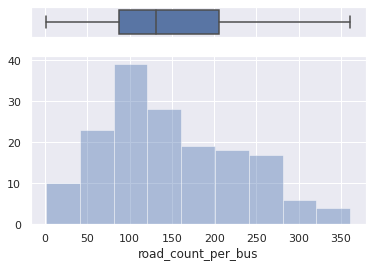

In [132]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(bus_unique_overlap["road_count_per_bus"], ax=ax_box)
sns.distplot(a=bus_unique_overlap["road_count_per_bus"], ax=ax_hist, hist=True, kde=False, rug=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

#### b. bus count per road (intersection)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


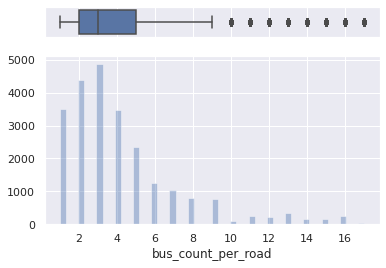

In [133]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(BusRoute_overlap["bus_count_per_road"], ax=ax_box)
sns.distplot(a=BusRoute_overlap["bus_count_per_road"], ax=ax_hist, hist=True, kde=False, rug=False)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### 3.5 Find similar bus stop

We would like to use clustering to find the bus stop with similar situations with regards to road coverage and seinor capacity.

In [134]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn import preprocessing

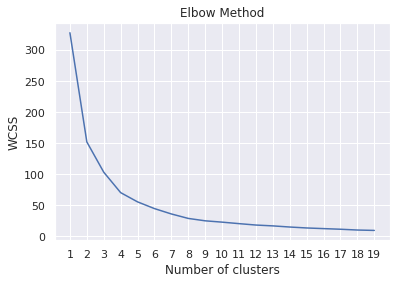

In [135]:
km = preprocessing.scale(bus_unique_overlap[['road_count_per_bus','total_senior_time']])
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(km)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.xticks(range(1,20))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the elbow method result, we could see that the slope change severelly at cluster number = 4 and/or 8.

Lets compare the result wiht it.

In [136]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
bus_unique_overlap['4cluster'] = kmeans.fit_predict(km)
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
bus_unique_overlap['8cluster'] = kmeans.fit_predict(km)

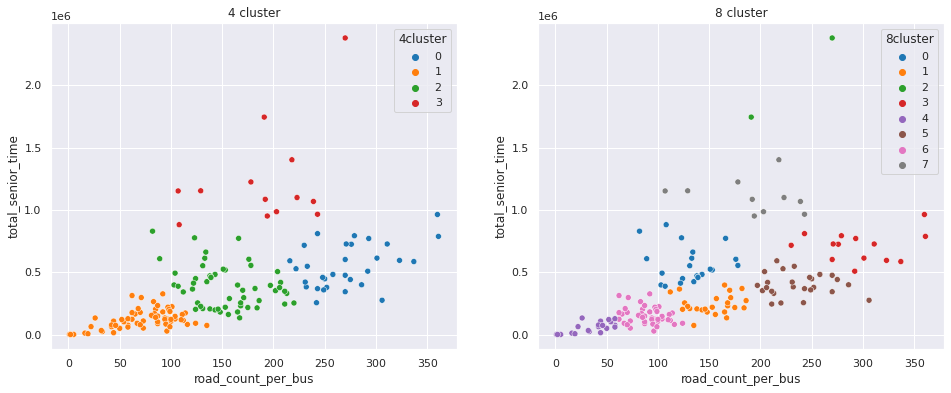

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title('4 cluster')
sns.scatterplot(x = 'road_count_per_bus', y = 'total_senior_time', \
    data=bus_unique_overlap, hue = '4cluster', palette='tab10',ax = ax1)
ax2.set_title('8 cluster')
sns.scatterplot(x = 'road_count_per_bus', y = 'total_senior_time', \
    data=bus_unique_overlap, hue = '8cluster', palette='tab10',ax = ax2)

In [138]:
bus_unique_overlap[bus_unique_overlap['8cluster'] == 2]

IDRoute  road_count_per_bus  total_senior_time  4cluster  8cluster
130      133                 270       2.380841e+06         3         2
149      152                 191       1.745576e+06         3         2

In [139]:
result[result['IDRoute'] == 133]['County_of_Origin'].unique()

array(['Setúbal', 'Porto', 'Maia', 'Gondomar', 'Oeiras', 'Odivelas',
       'Barreiro', 'Cascais'], dtype=object)

In [140]:
result[result['IDRoute'] == 152]['County_of_Origin'].unique()

array(['Porto', 'Sintra', 'Maia', 'Gondomar', 'Cascais', 'Lisboa',
       'Oeiras', 'Barreiro', 'Vila Franca de Xira'], dtype=object)

## 4. Preliminary from geographic perspective

In [141]:
road_unique = road_unique.reset_index()
road_unique_overlap = pd.merge(pd.DataFrame(road_in_both,columns=['linkid']),road_unique,how='left',on=['linkid'])

In [142]:
Churn_OD_no_dup = pd.merge(Churn_OD_no_dup,road_unique_overlap,how='left',on=['linkid'])
Churn_OD_no_dup.head()

linkid  ... bus_count_per_road
0  80216810  ...                2.0
1  80216810  ...                2.0
2  80216810  ...                2.0
3  80216810  ...                2.0
4  80216812  ...                3.0

[5 rows x 6 columns]

### 4.1 Region

In [143]:
region = Churn_OD_no_dup.groupby(Churn_OD_no_dup['Region_of_Origin']) \
         ['linkid'].nunique().reset_index(name = 'road_count')
region['bus_count'] = result.groupby('Region_of_Origin')['IDRoute'].nunique() \
                      .reset_index(name = 'bus_count')['bus_count']
region['no_bus_road'] = result[result['IDRoute'].isnull() == True]. \
                        groupby('Region_of_Origin')['linkid'].nunique() \
                        .reset_index(name = 'no_bus_road')['no_bus_road']
region['bus%'] = 1 - region['no_bus_road']/region['road_count']
region['total_senior_time'] = Churn_OD_no_dup.groupby(['Region_of_Origin']) \
                              ['Average_Daily_SeniorPopulation_Travelling'] \
                              .sum().reset_index(name = 'total_senior_time') \
                              ['total_senior_time']
region['bus_senior_time'] = Churn_OD_no_dup[~Churn_OD_no_dup['bus_count_per_road'].isnull()] \
    .groupby(['Region_of_Origin'])['Average_Daily_SeniorPopulation_Travelling'].sum() \
    .reset_index(name = 'bus_senior_time')['bus_senior_time']
region['bus_senior_time%'] = region['bus_senior_time']/region['total_senior_time']
region['mean'] = Churn_OD_no_dup.groupby(Churn_OD_no_dup['Region_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].mean(). \
                reset_index(name = 'mean')['mean']
region['std'] = Churn_OD_no_dup.groupby(Churn_OD_no_dup['Region_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].std(). \
                reset_index(name = 'std')['std']
region['max'] = Churn_OD_no_dup.groupby(Churn_OD_no_dup['Region_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].max(). \
                reset_index(name = 'max')['max']
region['min'] = Churn_OD_no_dup.groupby(Churn_OD_no_dup['Region_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].min(). \
                reset_index(name = 'min')['min']

### 4.2 District

In [144]:
district = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
         ['linkid'].nunique().reset_index(name = 'road_count')
district['bus_count'] = result.groupby(['Region_of_Origin','District_of_Origin'])['IDRoute'] \
                      .nunique().reset_index(name = 'bus_count')['bus_count']
district['no_bus_road'] = result[result['IDRoute'].isnull() == True]. \
                        groupby(['Region_of_Origin','District_of_Origin'])['linkid'].nunique() \
                        .reset_index(name = 'no_bus_road')['no_bus_road']
district['bus%'] = 1 - district['no_bus_road']/district['road_count']
district['total_senior_time'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
                              ['Average_Daily_SeniorPopulation_Travelling'] \
                              .sum().reset_index(name = 'total_senior_time') \
                              ['total_senior_time']
district['bus_senior_time'] = Churn_OD_no_dup[~Churn_OD_no_dup['bus_count_per_road'].isnull()] \
                              .groupby(['Region_of_Origin','District_of_Origin']) \
                              ['Average_Daily_SeniorPopulation_Travelling'].sum() \
                              .reset_index(name = 'bus_senior_time')['bus_senior_time']
district['bus_senior_time%'] = district['bus_senior_time']/district['total_senior_time']
district['mean'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].mean(). \
                reset_index(name = 'mean')['mean']
district['std'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].std(). \
                reset_index(name = 'std')['std']
district['max'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].max(). \
                reset_index(name = 'max')['max']
district['min'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].min(). \
                reset_index(name = 'min')['min']

### 4.3 County


In [145]:
county = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
         ['linkid'].nunique().reset_index(name = 'road_count')
county['bus_count'] = result.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin'])['IDRoute'] \
                      .nunique().reset_index(name = 'bus_count')['bus_count']
county['no_bus_road'] = result[result['IDRoute'].isnull() == True]. \
                        groupby(['Region_of_Origin','District_of_Origin','County_of_Origin'])['linkid'].nunique() \
                        .reset_index(name = 'no_bus_road')['no_bus_road']
county['bus%'] = 1 - county['no_bus_road']/county['road_count']##!!!!!!!!!!bus road/ road count
county['total_senior_time'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
                              ['Average_Daily_SeniorPopulation_Travelling'] \
                              .sum().reset_index(name = 'total_senior_time') \
                              ['total_senior_time']
county_bus_senior_time = Churn_OD_no_dup[~Churn_OD_no_dup['bus_count_per_road'].isnull()] \
    .groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
    ['Average_Daily_SeniorPopulation_Travelling'] \
    .sum().reset_index(name = 'bus_senior_time')['bus_senior_time']
line = pd.DataFrame({'bus_senior_time':0}, index=[12])
county_bus_senior_time = pd.DataFrame(county_bus_senior_time)
county_bus_senior_time = pd.concat([county_bus_senior_time.iloc[:12], \
                         line,county_bus_senior_time.iloc[12:]]).reset_index(drop=True)
county['bus_senior_time'] = county_bus_senior_time['bus_senior_time']
county['bus_senior_time%'] = county['bus_senior_time']/county['total_senior_time']
county['mean'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].mean(). \
                reset_index(name = 'mean')['mean']
county['std'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].std(). \
                reset_index(name = 'std')['std']
county['max'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].max(). \
                reset_index(name = 'max')['max']
county['min'] = Churn_OD_no_dup.groupby(['Region_of_Origin','District_of_Origin','County_of_Origin']) \
                ['Average_Daily_SeniorPopulation_Travelling'].min(). \
                reset_index(name = 'min')['min']

## 5. Import Senior Population Data

The population information is downloaded from the open sourse (https://www.pordata.pt/DB/Municipios/Ambiente+de+Consulta/Tabela). 

It has been sorted in excel before applied in the following process.

The sorted dataset has been saved at (https://raw.githubusercontent.com/rainieluo2016/WDL/main/older_population.csv)

### 5.1 Import

In [146]:
senior="https://raw.githubusercontent.com/rainieluo2016/WDL/main/older_population.csv"
senior=pd.read_csv(senior, encoding= 'unicode_escape',delimiter = ",")
senior['65+'] = senior['65+'].apply(lambda x: float(x.strip().replace(',','')))
senior['senior%'] = senior['65+']/senior['total']

In [147]:
senior.columns.values[0] = 'Region_of_Origin'
senior.columns.values[1] = 'District_of_Origin'

### 5.2 Add seinor information to geographic tables

+ senior pop: population over 65 years old
+ avg_senior_times: travel frequency for seniors on average

In [148]:
county['senior_pop'] = senior['65+']
county['senior%'] = senior['senior%']
county['avg_senior_times'] = county['total_senior_time']/county['senior_pop']

### 5.3 Find similar county

Having information about average senior travelling per county and seinor population percentage, let's find the county with similar situations.

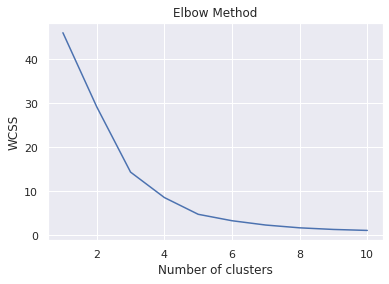

In [149]:
km = preprocessing.scale(county[['avg_senior_times','senior%']])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(km)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We would like to pick cluster number =3 or 5 based on the result.

In [150]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
county['3cluster'] = kmeans.fit_predict(km)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
county['5cluster'] = kmeans.fit_predict(km)

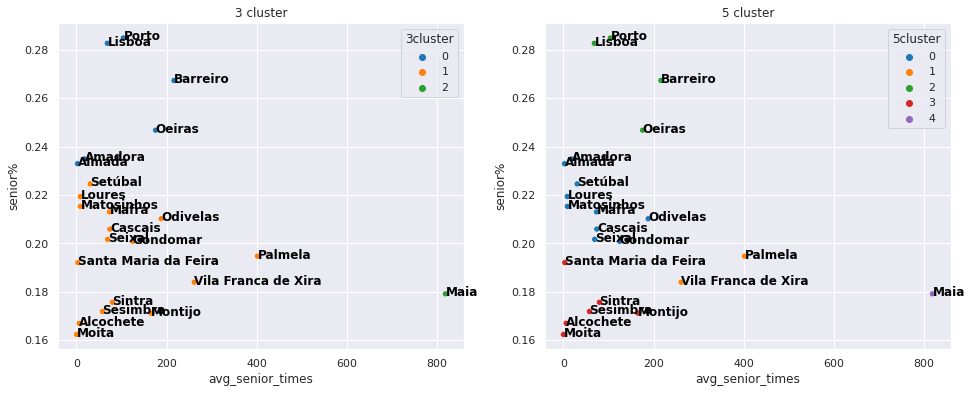

In [151]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

for line in range(0,county.shape[0]):
     ax1.text(county['avg_senior_times'][line]+0.3, county['senior%'][line]-0.001, \
         county['County_of_Origin'][line], horizontalalignment='left',  \
         size='medium', color='black', weight='semibold')
     ax2.text(county['avg_senior_times'][line]+0.3, county['senior%'][line]-0.001, \
         county['County_of_Origin'][line], horizontalalignment='left',  \
         size='medium', color='black', weight='semibold')
ax1.set_title('3 cluster')
sns.scatterplot(x='avg_senior_times', y='senior%', data=county, ax=ax1,hue='3cluster',palette='tab10')
ax2.set_title('5 cluster')
sns.scatterplot(x='avg_senior_times', y='senior%', data=county, ax=ax2,hue='5cluster',palette='tab10')


Based on the comparison of those two clustering output, 


*   __Maia__ is a very special county that it has very high average senior transportation but very low senior population percentage. This is due to its geographic reason that it's close to sea and has hills. 
*   Other than Maia, the five clustering splits the counties into 4 different categories. 
  + Palmela and Vila France de Xira perform quite good in terms of average senior time and senior percentage.
  + Porto, Lisboa and other two counties obviously have large senior population % and comparible low senior traveling.
  + Almada and other 9 counties could be considered as medium in terms of senior population %.
  + Santa Maria da Feira, Moita and 4 other counties could be considered as small in terms of senior population %. 





## 6. Xgboost tree visualization

In [152]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [153]:
dummies=pd.get_dummies(Churn_OD)
dummies["Average_Daily_SeniorPopulation_Travelling"]=(dummies.Average_Daily_SeniorPopulation_Travelling-min(dummies.Average_Daily_SeniorPopulation_Travelling))/(max(dummies.Average_Daily_SeniorPopulation_Travelling)-min(dummies.Average_Daily_SeniorPopulation_Travelling))
X, y = dummies.iloc[:,2:31],dummies.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [154]:
xg_reg = xgb.XGBRegressor(booster="gbtree",
              objective='reg:linear',
              learning_rate=0.001,
              colsample_bytree = 0.3,
              verbose=False,
              n_estimators=1000,
              max_depth=10,
              early_stopping_rounds=20)


In [155]:
xg_reg.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

[00:43:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, early_stopping_rounds=20,
             gamma=0, importance_type='gain', learning_rate=0.001,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbose=False, verbosity=1)

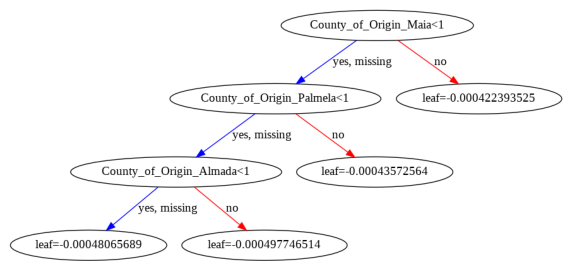

In [156]:
fig, ax = plt.subplots(figsize=(10, 10))  # whatever size you want
plot_tree(xg_reg, ax=ax)
plt.show()

By using xgboost linear regression, we got a tree model to find out which county is totally different from others. For example, since Maia is on the top of the tree which means Maia's average senior time would be the first part to separate with other places average senior time.

## 7. Problems and Solution

###7.1 Existing Problems Associated with Senior Transportation

https://www.aarp.org/content/dam/aarp/livable-communities/old-learn/transportation/Attracting-Senior-Drivers-to-Public-Transportation-Issues-and-Concerns-AARP.pdf

  As the world population grows and life expectancy of humans expands, senior population has drawn more attention than ever in terms of public policing. A 2010 report by the Federal Transit Administration addressed on seniors and public transportation pointed out some existing issues:


1.   A considerable portion of seniors choose to drive as they generally feel the need to maintain the independence as they had before reaching a certain age; yet safety on road is worth concerns;
2.   As the seniors age, when driving isn't an option, they would likely expect similar amount of freedom and flexibility on traveling;
3.   Not many can afford on-demand ride services such as taxi the majority of the times, so they would need to rely on public transportation. 



###7.2 Solution


1.   Free ride after sunset.
       
        For those seniors who drive, the risk of getting involved in an accident increases at night. Thus, we propose that the government offers free ride on public transportation from sunset to midnight. According to the sunlight pattern in Portugal, we suggest the following time frame for free public transportation targeting seniors: 19:00-midnight (April to October), 18:00-midnight (November to March). 

2.   First implement free-ride in Porto, Santa Maria da Feira, Almada. Porto: busy, populated, low travel rate. Santa Maria da Feira: representative in cluster 3 with low population and low travel rate. Almada: representative in cluster 0 and a cutoff from xgboost trees. 
      
      Slightly raise expenses on public transportation for tourists. 

 
3.   Sepecial transportation cards for seniors. 

        Keep track on traveling behaviors of seniors more accurately. 

